# Reading FC Season Progress

The following analysis showcases Reading FC's Performance in the season for the first third of the season (15 games)

Analysis includes:

- Overall Performance
- Attacking Performance
- Game Play Performance
- Defensive Performance
- Goalkeeper Performance

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('../../../../data/rfc_matchdata.csv')
df.head()


,Opponent,Round,Date,rfc_league_position,opp_league_position,rfc_Score,opp_Score,Result,Venue,rfc_xG_1st,...,opp_Interceptions,opp_GK_Saves_1st,opp_GK_Saves_2nd,opp_GK_Saves,opp_xGOT_Faced_1st,opp_xGOT_Faced_2nd,opp_xGOT_Faced,opp_GK_Goals_Prevented_1st,opp_GK_Goals_Prevented_2nd,opp_GK_Goals_Prevented
0,Lincoln,1,02/08/2025,NaN,NaN,0,2,L,A,0.06,...,13,1,1,2,0.13,0.43,0.56,0.13,0.43,0.56
1,Huddersfield,2,09/08/2025,23.0,2.0,0,2,L,H,0.15,...,8,0,2,2,0.00,0.41,0.41,0.00,0.41,0.41
2,Wimbledon,3,16/08/2025,24.0,10.0,1,2,L,H,0.49,...,3,0,2,2,0.00,0.52,0.52,0.00,-0.48,-0.48
3,Bolton,4,20/08/2025,22.0,16.0,1,1,D,A,0.00,...,3,0,1,1,0.00,0.49,0.49,0.00,-0.51,-0.51
4,Wycombe,5,23/08/2025,21.0,20.0,2,2,D,A,0.36,...,8,2,2,4,0.39,0.30,0.69,-1.61,0.30,-1.31


# Overall Performance

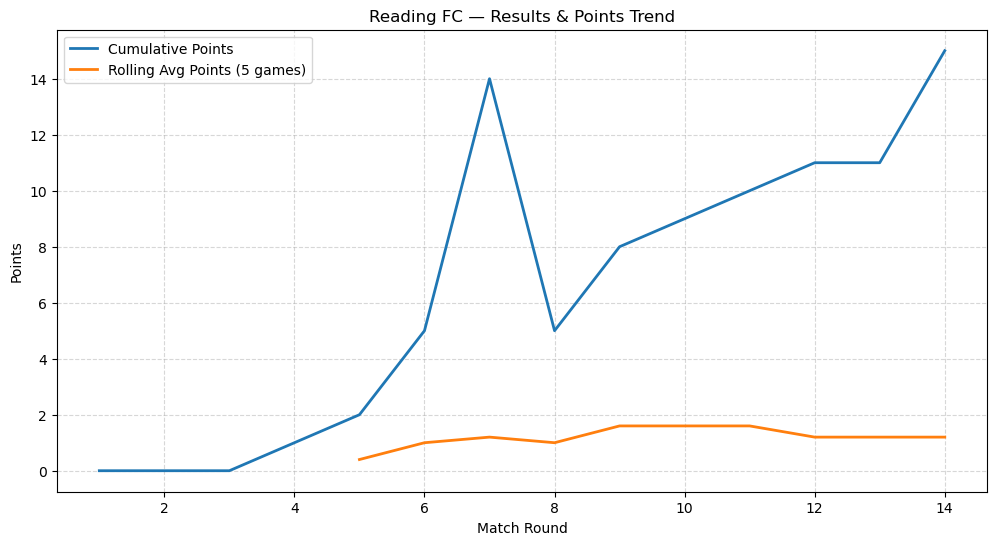

In [59]:
# Function to map results to points
def result_to_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

# Apply points calculation
df['Points'] = df['Result'].apply(result_to_points)

# Cumulative points and rolling form (last 5 matches)
df['Cumulative Points'] = df['Points'].cumsum()
df['Rolling Points (5 games)'] = df['Points'].rolling(window=5).mean()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Round', y='Cumulative Points', label='Cumulative Points', linewidth=2)
sns.lineplot(data=df, x='Round', y='Rolling Points (5 games)', label='Rolling Avg Points (5 games)', linewidth=2)

plt.title("Reading FC — Results & Points Trend")
plt.xlabel("Match Round")
plt.ylabel("Points")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [60]:
# ---------------------------
# Prep & helper functions
# ---------------------------
df = df.copy()

# Parse dates & sort
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values(['Date', 'Round'], na_position='last').reset_index(drop=True)
else:
    df = df.sort_values('Round').reset_index(drop=True)

# Ensure opponent totals exist
def ensure_total(col):
    c1, c2 = f"{col}_1st", f"{col}_2nd"
    if col not in df.columns and c1 in df.columns and c2 in df.columns:
        df[col] = df[c1] + df[c2]

for col in ['rfc_xG', 'opp_xG',
            'rfc_Shots', 'opp_Shots',
            'rfc_SOT', 'opp_SOT',
            'rfc_Touches_In_Opp_Box', 'opp_Touches_In_Opp_Box',
            'rfc_Passes_In_Final_Third', 'opp_Passes_In_Final_Third',
            'rfc_Crosses', 'opp_Crosses']:
    ensure_total(col)

# Possession 
if 'rfc_Possesion' in df.columns:
    df['rfc_Possession'] = df['rfc_Possesion']
elif 'rfc_Possession_1st' in df.columns and 'rfc_Possession_2nd' in df.columns:
    df['rfc_Possession'] = (df['rfc_Possession_1st'] + df['rfc_Possession_2nd']) / 2

if 'opp_Possesion' in df.columns:
    df['opp_Possession'] = df['opp_Possesion']
elif 'opp_Possession_1st' in df.columns and 'opp_Possession_2nd' in df.columns:
    df['opp_Possession'] = (df['opp_Possession_1st'] + df['opp_Possession_2nd']) / 2

# Points from results
points_map = {'W': 3, 'D': 1, 'L': 0}
df['Points'] = df['Result'].map(points_map).fillna(0).astype(float)

# xG diff (Reading – Opp)
df['xG_diff'] = df['rfc_xG'] - df['opp_xG']

# --- Position Gap ---
# IMPORTANT: lower rank number = higher in table (1st is best).
# Define gap so that positive values mean the OPPONENT is higher-placed than Reading.
# Example: Reading 17th, Opp 12th -> gap = 17 - 12 = +5 (opponent higher in table)
df['position_gap'] = df['rfc_league_position'] - df['opp_league_position']

# Opponent strength tiers
def opp_tier(rank):
    if pd.isna(rank): return np.nan
    r = int(rank)
    if 1 <= r <= 6: return 'Top 6'
    if 7 <= r <= 12: return '7–12'
    if 13 <= r <= 18: return '13–18'
    if 19 <= r <= 24: return '19–24'
    return 'Other'

df['opp_tier'] = df['opp_league_position'].apply(opp_tier)
tier_order = ['Top 6', '7–12', '13–18', '19–24']

# Rolling window
W = 5
df['roll_xG_diff'] = df['xG_diff'].rolling(W).mean()

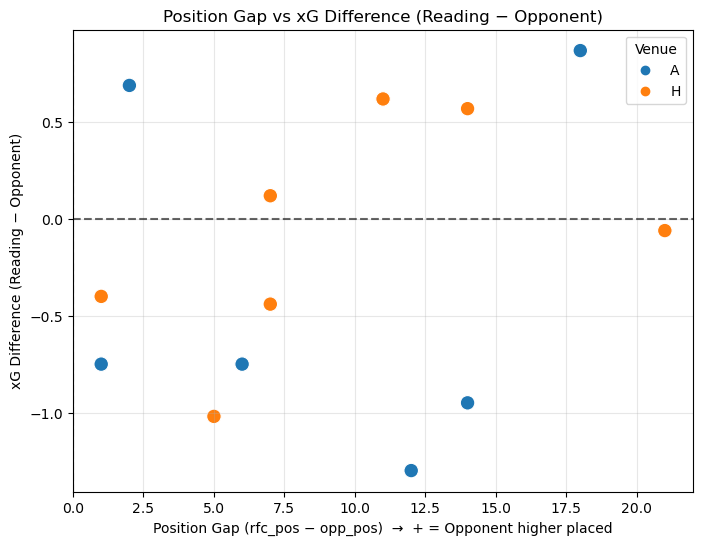

In [61]:
# ---------------------------
# Scatter: Position gap vs xG difference
# ---------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='position_gap', y='xG_diff', hue='Venue', s=110)
plt.axhline(0, ls='--', c='k', alpha=0.6)
plt.axvline(0, ls='--', c='k', alpha=0.6)
plt.title("Position Gap vs xG Difference (Reading − Opponent)")
plt.xlabel("Position Gap (rfc_pos − opp_pos)  →  + = Opponent higher placed")
plt.ylabel("xG Difference (Reading − Opponent)")
plt.grid(alpha=0.3)
plt.show()

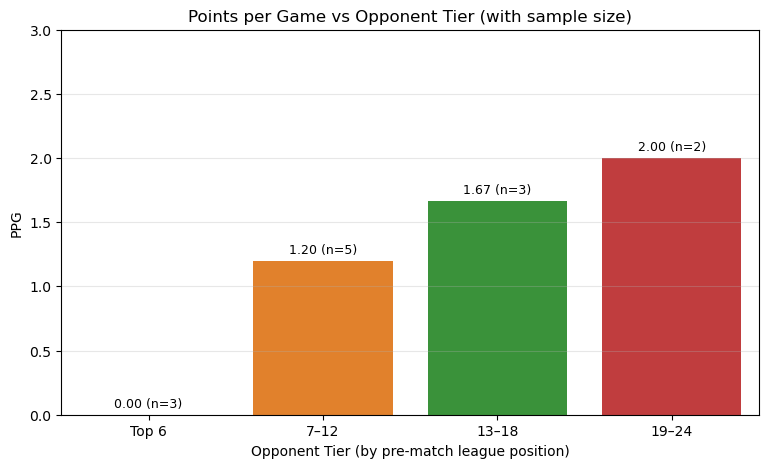

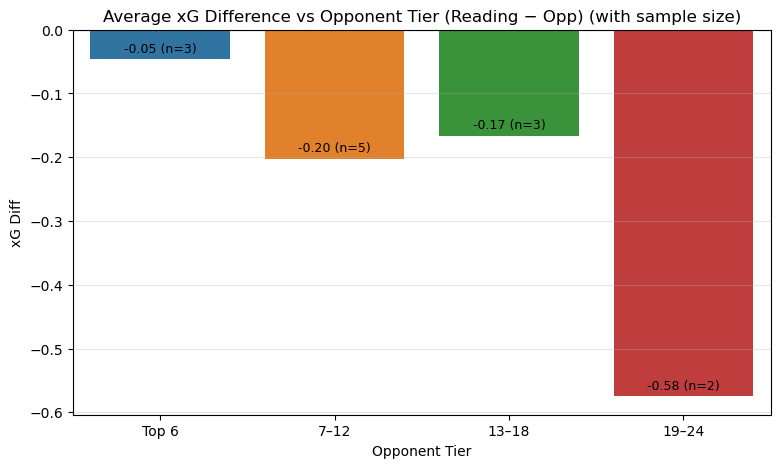

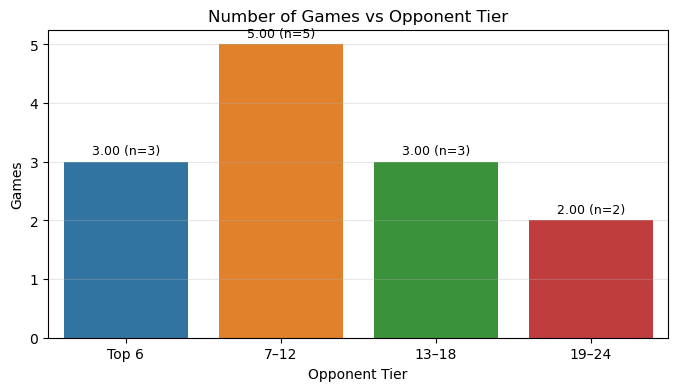

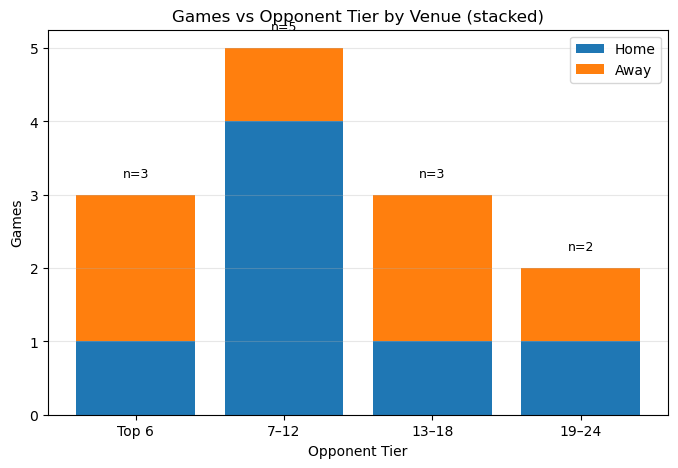

PPG & xG Diff by Opponent Tier (with sample sizes)


,Games,Points_total,PPG,xG_diff
opp_tier,,,,
Top 6,3,0.0,0.000000,-0.046667
7–12,5,6.0,1.200000,-0.202000
13–18,3,5.0,1.666667,-0.166667
19–24,2,4.0,2.000000,-0.575000


In [62]:
# ---------------------------
# Bar: Points per game vs Opponent Tier — with sample sizes
# ---------------------------

# Rebuild the agg with Games + total Points
ppg_by_tier = (
    df.groupby('opp_tier', as_index=False)
      .agg(
          Games=('Points', 'size'),
          Points_total=('Points', 'sum'),
          PPG=('Points', lambda s: s.mean() if len(s) else float('nan')),
          xG_diff=('xG_diff', 'mean')
      )
      .dropna(subset=['opp_tier'])
      .set_index('opp_tier')
      .reindex(tier_order)
)

# Helper to annotate bars with counts
def annotate_counts(ax, counts, fmt=" (n={})"):
    for p, n in zip(ax.patches, counts):
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}" + (fmt.format(int(n)) if pd.notna(n) else ""),
            (p.get_x() + p.get_width()/2., height),
            ha='center', va='bottom', fontsize=9, rotation=0, xytext=(0, 3), textcoords='offset points'
        )

# --- PPG bar with n
plt.figure(figsize=(9,5))
ax = sns.barplot(x=ppg_by_tier.index, y=ppg_by_tier['PPG'])
plt.title("Points per Game vs Opponent Tier (with sample size)")
plt.xlabel("Opponent Tier (by pre-match league position)")
plt.ylabel("PPG")
plt.ylim(0, 3)
plt.grid(axis='y', alpha=0.3)

annotate_counts(ax, ppg_by_tier['Games'].fillna(0))
plt.show()

# --- xG diff bar with n
plt.figure(figsize=(9,5))
ax = sns.barplot(x=ppg_by_tier.index, y=ppg_by_tier['xG_diff'])
plt.title("Average xG Difference vs Opponent Tier (Reading − Opp) (with sample size)")
plt.xlabel("Opponent Tier")
plt.ylabel("xG Diff")
plt.axhline(0, ls='--', c='k', alpha=0.6)
plt.grid(axis='y', alpha=0.3)

annotate_counts(ax, ppg_by_tier['Games'].fillna(0))
plt.show()

# ---------------------------
# (Optional) Games played vs Opponent Tier — overall and by Venue
# ---------------------------

# Overall games per tier
games_per_tier = (
    df.groupby('opp_tier', as_index=False)
      .agg(Games=('Round','size'))
      .dropna(subset=['opp_tier'])
      .set_index('opp_tier')
      .reindex(tier_order)
)

plt.figure(figsize=(8,4))
ax = sns.barplot(x=games_per_tier.index, y=games_per_tier['Games'])
plt.title("Number of Games vs Opponent Tier")
plt.xlabel("Opponent Tier")
plt.ylabel("Games")
plt.grid(axis='y', alpha=0.3)

# annotate counts (redundant but keeps style consistent)
annotate_counts(ax, games_per_tier['Games'])
plt.show()

# Home/Away split (stacked)
games_ha = (
    df.groupby(['opp_tier','Venue'], as_index=False)
      .agg(Games=('Round','size'))
      .pivot(index='opp_tier', columns='Venue', values='Games')
      .reindex(tier_order)
      .fillna(0)
)

# Make stacked bars for H/A if both columns exist
plt.figure(figsize=(8,5))
bottom = None
for venue in ['H','A']:
    if venue in games_ha.columns:
        plt.bar(games_ha.index, games_ha[venue], bottom=bottom, label={'H':'Home','A':'Away'}[venue])
        bottom = (games_ha[venue] if bottom is None else bottom + games_ha[venue])

plt.title("Games vs Opponent Tier by Venue (stacked)")
plt.xlabel("Opponent Tier")
plt.ylabel("Games")
plt.legend()
plt.grid(axis='y', alpha=0.3)

# annotate totals on top of stacks
totals = games_ha.sum(axis=1)
for i, (tier, total) in enumerate(totals.items()):
    plt.text(i, total + 0.2, f"n={int(total)}", ha='center', va='bottom', fontsize=9)

plt.show()

# ---------------------------
# (Optional) Tabular view you can print/inspect
# ---------------------------
summary_tbl = ppg_by_tier[['Games','Points_total','PPG','xG_diff']].copy()
print("PPG & xG Diff by Opponent Tier (with sample sizes)")
display(summary_tbl)


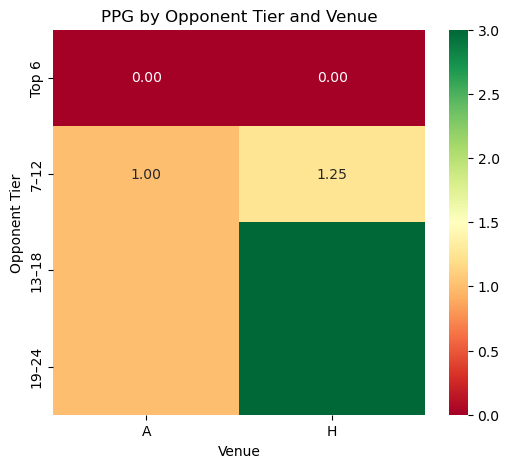

In [63]:
# ---------------------------
# Heatmap: Home/Away × Opp Strength (PPG)
# ---------------------------
ppg_hm = (df
    .groupby(['opp_tier','Venue'], as_index=False)
    .agg(PPG=('Points','mean'))
    .pivot(index='opp_tier', columns='Venue', values='PPG')
    .reindex(tier_order))

plt.figure(figsize=(6,5))
sns.heatmap(ppg_hm, annot=True, fmt=".2f", cmap='RdYlGn', vmin=0, vmax=3)
plt.title("PPG by Opponent Tier and Venue")
plt.xlabel("Venue")
plt.ylabel("Opponent Tier")
plt.show()

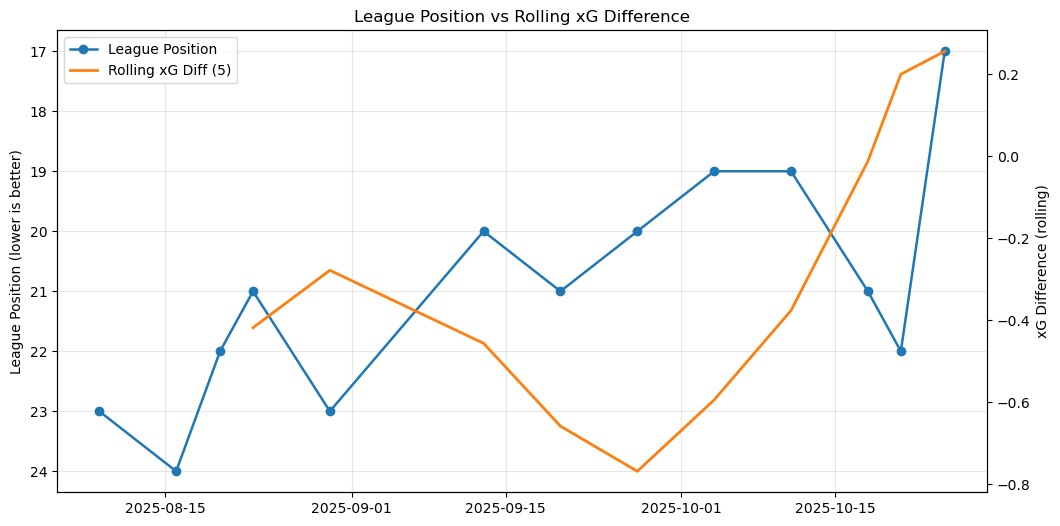

In [64]:
# ---------------------------
# Line: League position vs rolling xG diff
# ---------------------------
# X axis (Date preferred)
xcol = 'Date' if 'Date' in df.columns and df['Date'].notna().any() else 'Round'

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()

# League position (lower is better) – invert axis
ax1.plot(df[xcol], df['rfc_league_position'], marker='o', linewidth=1.8, label='League Position')
ax1.set_ylabel("League Position (lower is better)")
ax1.invert_yaxis()

# Rolling xG difference
ax2.plot(df[xcol], df['roll_xG_diff'], linestyle='-', linewidth=2, color='tab:orange', label=f'Rolling xG Diff ({W})')
ax2.set_ylabel("xG Difference (rolling)")

ax1.set_title("League Position vs Rolling xG Difference")
ax1.grid(alpha=0.3)
# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

In [65]:
# ---------------------------
# Upset Table (and bad losses)
# ---------------------------
# Favourite if Reading higher in table (smaller number)
df['is_favourite'] = df['rfc_league_position'] < df['opp_league_position']
df['is_underdog'] = df['rfc_league_position'] > df['opp_league_position']

upset_wins = df[(df['is_underdog']) & (df['Result'] == 'W')].copy()
bad_losses = df[(df['is_favourite']) & (df['Result'] == 'L')].copy()

cols_show = ['Date','Round','Venue','Opponent','rfc_league_position','opp_league_position',
             'Result','Points','rfc_Score','opp_Score','xG_diff']

print("=== Upset Wins (Reading beat higher-placed opponents) ===")
display(upset_wins[cols_show].sort_values(xcol if xcol in cols_show else 'Round'))

print("\n=== Bad Losses (Reading lost to lower-placed opponents) ===")
display(bad_losses[cols_show].sort_values(xcol if xcol in cols_show else 'Round'))

=== Upset Wins (Reading beat higher-placed opponents) ===


,Date,Round,Venue,Opponent,rfc_league_position,opp_league_position,Result,Points,rfc_Score,opp_Score,xG_diff
5,2025-08-30,6,H,Port Vale,23.0,22.0,W,3.0,1,0,-0.40
7,2025-09-20,9,H,Leyton Orient,21.0,14.0,W,3.0,2,1,-0.44
12,2025-10-21,7,H,Northampton,22.0,11.0,W,3.0,1,0,0.62



=== Bad Losses (Reading lost to lower-placed opponents) ===


,Date,Round,Venue,Opponent,rfc_league_position,opp_league_position,Result,Points,rfc_Score,opp_Score,xG_diff


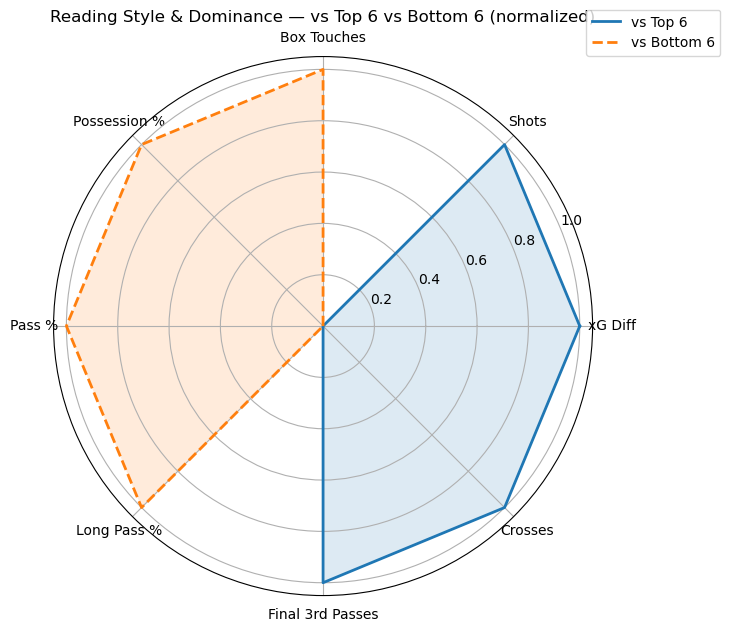

In [66]:
# ---------------------------
# Radar: Top 6 vs Bottom 6 performance
# ---------------------------
# Metrics for style + dominance (use means)
radar_metrics = {
    "xG Diff": "xG_diff",
    "Shots": "rfc_Shots",
    "Box Touches": "rfc_Touches_In_Opp_Box",
    "Possession %": "rfc_Possession",
    "Pass %": "rfc_Pass%",
    "Long Pass %": "rfc_LongPass%",
    "Final 3rd Passes": "rfc_Passes_In_Final_Third",
    "Crosses": "rfc_Crosses",
}

# Compute group means
top6 = df[df['opp_league_position'].between(1,6, inclusive='both')]
bot6 = df[df['opp_league_position'].between(19,24, inclusive='both')]

def group_means(group, metrics):
    out = {}
    for label, col in metrics.items():
        if col in group.columns:
            out[label] = group[col].mean()
        else:
            out[label] = np.nan
    return out

top_means = group_means(top6, radar_metrics)
bot_means = group_means(bot6, radar_metrics)

# Standardize each metric to 0–1 using min/max across the two groups (so overlay is comparable)
labels = list(radar_metrics.keys())
top_vals, bot_vals = [], []
for lab in labels:
    a = top_means[lab]
    b = bot_means[lab]
    arr = np.array([a, b], dtype=float)
    if np.all(np.isnan(arr)):
        top_vals.append(0.0); bot_vals.append(0.0)
        continue
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    rng = (mx - mn) if (mx - mn) != 0 else 1.0
    top_vals.append((a - mn)/rng if not np.isnan(a) else 0.0)
    bot_vals.append((b - mn)/rng if not np.isnan(b) else 0.0)

# Close the loop
theta = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
theta = np.concatenate([theta, [theta[0]]])
top_plot = np.concatenate([top_vals, [top_vals[0]]])
bot_plot = np.concatenate([bot_vals, [bot_vals[0]]])

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)
ax.plot(theta, top_plot, linewidth=2, label='vs Top 6')
ax.fill(theta, top_plot, alpha=0.15)
ax.plot(theta, bot_plot, linewidth=2, linestyle='--', label='vs Bottom 6')
ax.fill(theta, bot_plot, alpha=0.15)
ax.set_thetagrids(theta[:-1]*180/np.pi, labels)
ax.set_title("Reading Style & Dominance — vs Top 6 vs Bottom 6 (normalized)")
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))
plt.show()

# Attacking Performance

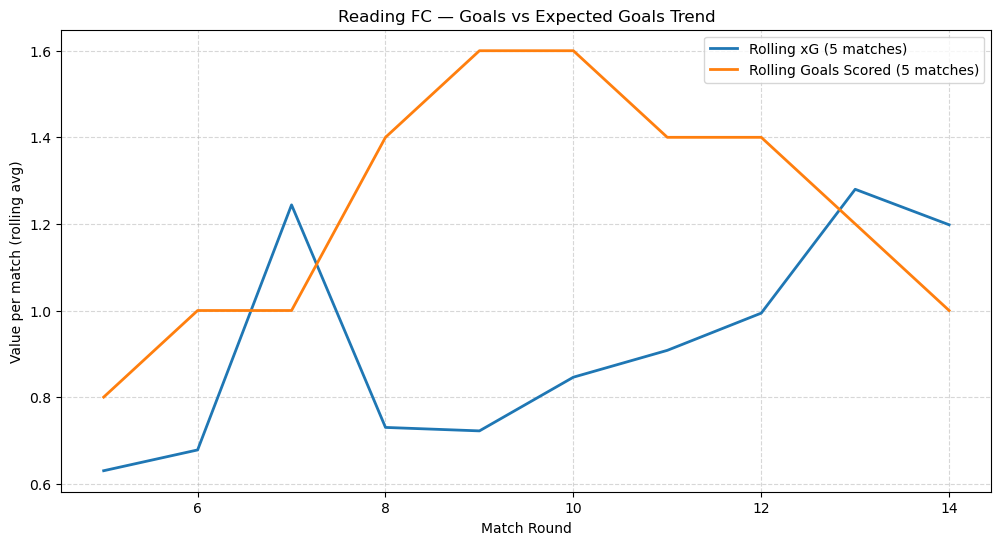

In [67]:
# Create xG difference column
df['xG_diff'] = df['rfc_xG'] - df['opp_xG']

# Rolling averages (last 5 matches)
df['Rolling_rfc_xG'] = df['rfc_xG'].rolling(window=5).mean()
df['Rolling_rfc_Goals'] = df['rfc_Score'].rolling(window=5).mean()

plt.figure(figsize=(12,6))

# Plot rolling goals vs rolling xG
sns.lineplot(data=df, x='Round', y='Rolling_rfc_xG', label='Rolling xG (5 matches)', linewidth=2)
sns.lineplot(data=df, x='Round', y='Rolling_rfc_Goals', label='Rolling Goals Scored (5 matches)', linewidth=2)

plt.title("Reading FC — Goals vs Expected Goals Trend")
plt.xlabel("Match Round")
plt.ylabel("Value per match (rolling avg)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

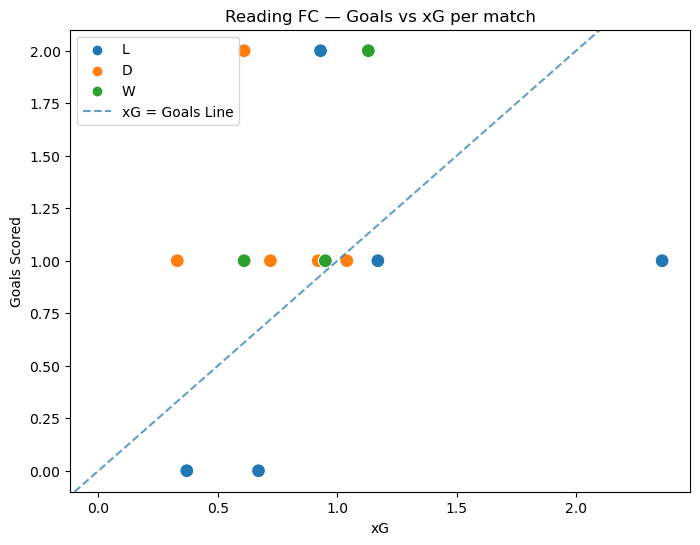

In [68]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=df, x='rfc_xG', y='rfc_Score', hue='Result', s=100)

plt.axline((0,0), slope=1, linestyle='--', alpha=0.7, label='xG = Goals Line')
plt.title("Reading FC — Goals vs xG per match")
plt.xlabel("xG")
plt.ylabel("Goals Scored")
plt.legend()
plt.show()

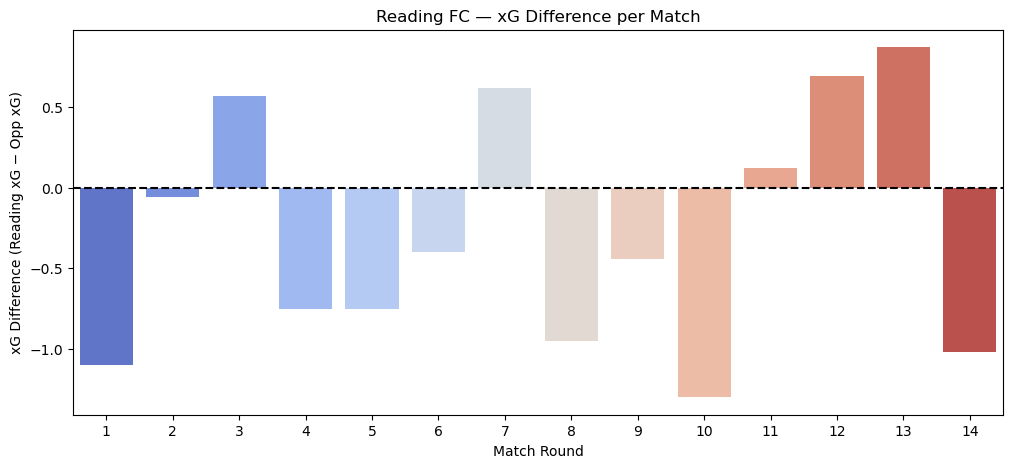

In [69]:
plt.figure(figsize=(12,5))

sns.barplot(data=df, x='Round', y='xG_diff', palette='coolwarm')

plt.axhline(0, linestyle="--", color='black')
plt.title("Reading FC — xG Difference per Match")
plt.xlabel("Match Round")
plt.ylabel("xG Difference (Reading xG − Opp xG)")
plt.show()


In [70]:
# Avoid division errors
df['Shot_Conversion%'] = df['rfc_Score'] / df['rfc_Shots']
df['Shot_OnTarget%'] = df['rfc_SOT'] / df['rfc_Shots']
df['xG_per_Shot'] = df['rfc_xG'] / df['rfc_Shots']
df['Inside_Box_Shot%'] = df['rfc_Shots_Inside_Box'] / df['rfc_Shots']

# Replacing inf or NaN if any games had zero shots
df.replace([float('inf'), -float('inf')], 0, inplace=True)
df.fillna(0, inplace=True)


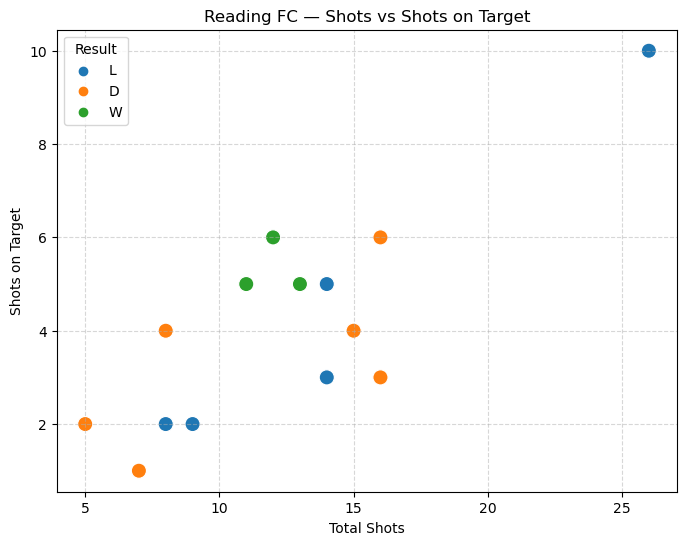

In [71]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='rfc_Shots', y='rfc_SOT', hue='Result', s=120)

plt.title("Reading FC — Shots vs Shots on Target")
plt.xlabel("Total Shots")
plt.ylabel("Shots on Target")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


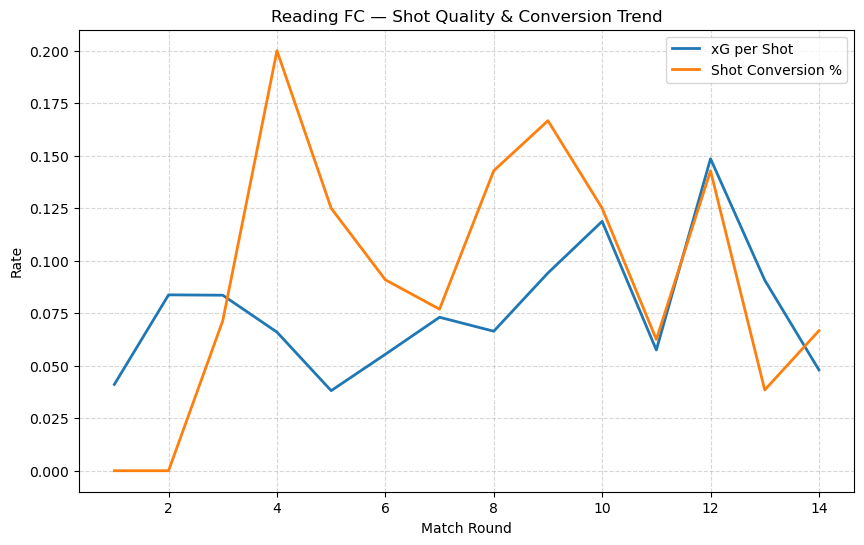

In [72]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Round', y='xG_per_Shot', label='xG per Shot', linewidth=2)
sns.lineplot(data=df, x='Round', y='Shot_Conversion%', label='Shot Conversion %', linewidth=2)

plt.title("Reading FC — Shot Quality & Conversion Trend")
plt.xlabel("Match Round")
plt.ylabel("Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


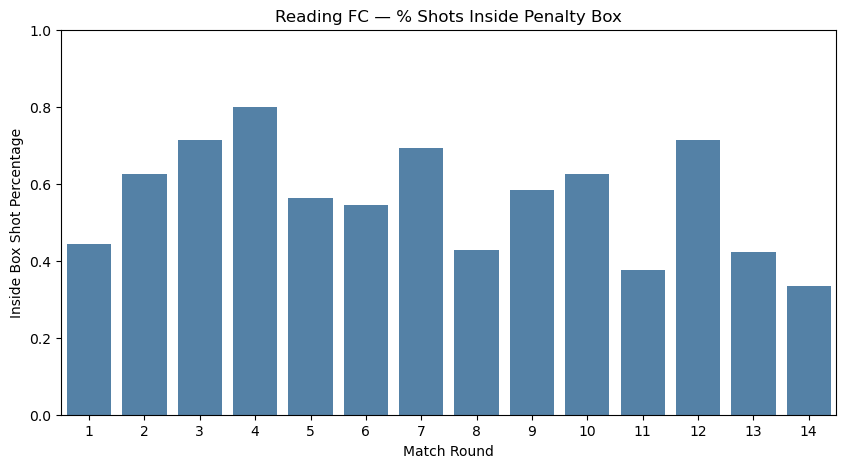

In [73]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Round', y='Inside_Box_Shot%', color='steelblue')

plt.title("Reading FC — % Shots Inside Penalty Box")
plt.xlabel("Match Round")
plt.ylabel("Inside Box Shot Percentage")
plt.ylim(0,1)
plt.show()


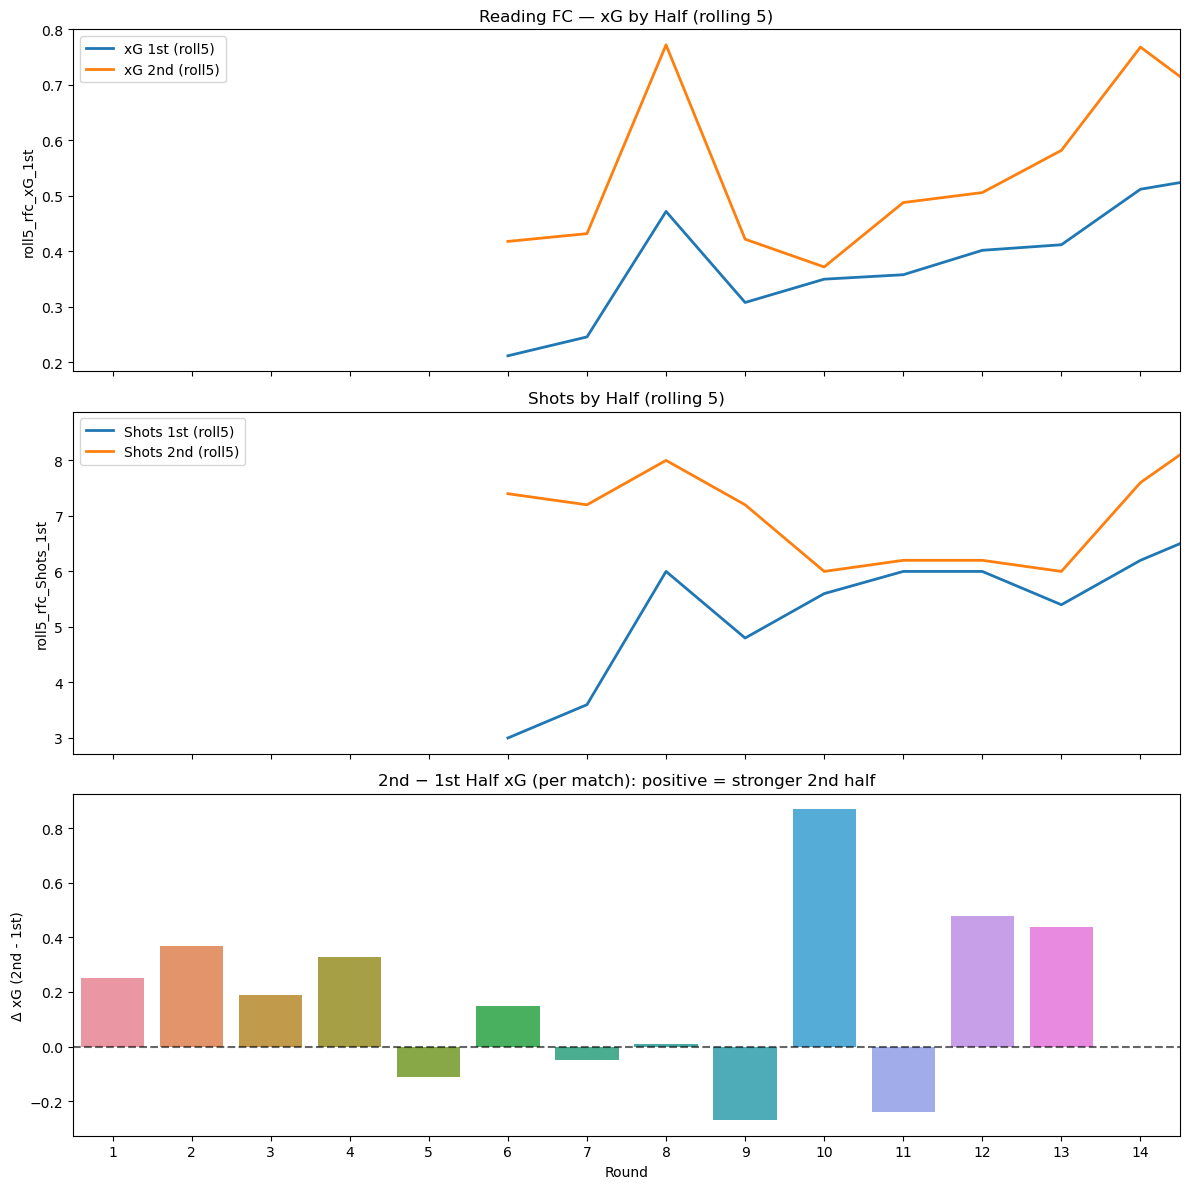

In [74]:
df['rfc_xG_delta_2nd_minus_1st'] = df['rfc_xG_2nd'] - df['rfc_xG_1st']
df['rfc_Shots_delta_2nd_minus_1st'] = df['rfc_Shots_2nd'] - df['rfc_Shots_1st']
df['rfc_SOT_delta_2nd_minus_1st'] = df['rfc_SOT_2nd'] - df['rfc_SOT_1st']

# Rolling by 5 matches
for col in ['rfc_xG_1st','rfc_xG_2nd','rfc_Shots_1st','rfc_Shots_2nd','rfc_SOT_1st','rfc_SOT_2nd',
            'rfc_xG_delta_2nd_minus_1st','rfc_Shots_delta_2nd_minus_1st','rfc_SOT_delta_2nd_minus_1st']:
    df[f'roll5_{col}'] = df[col].rolling(5).mean()

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
sns.lineplot(data=df, x='Round', y='roll5_rfc_xG_1st', label='xG 1st (roll5)', ax=axes[0], linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_rfc_xG_2nd', label='xG 2nd (roll5)', ax=axes[0], linewidth=2)
axes[0].set_title("Reading FC — xG by Half (rolling 5)")

sns.lineplot(data=df, x='Round', y='roll5_rfc_Shots_1st', label='Shots 1st (roll5)', ax=axes[1], linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_rfc_Shots_2nd', label='Shots 2nd (roll5)', ax=axes[1], linewidth=2)
axes[1].set_title("Shots by Half (rolling 5)")

sns.barplot(data=df, x='Round', y='rfc_xG_delta_2nd_minus_1st', ax=axes[2])
axes[2].axhline(0, ls='--', c='k', alpha=0.6)
axes[2].set_title("2nd − 1st Half xG (per match): positive = stronger 2nd half")
axes[2].set_ylabel("Δ xG (2nd - 1st)")
plt.tight_layout()
plt.show()

In [75]:
df['Goals_minus_xG'] = df['rfc_Score'] - df['rfc_xG']
df['OppGoals_minus_opp_xG'] = df['opp_Score'] - df['opp_xG']

df['rfc_xG_per_shot'] = df['rfc_xG'] / df['rfc_Shots']
df['opp_xG_per_shot'] = df['opp_xG'] / df['opp_Shots']

df.replace([float('inf'), -float('inf')], 0, inplace=True)


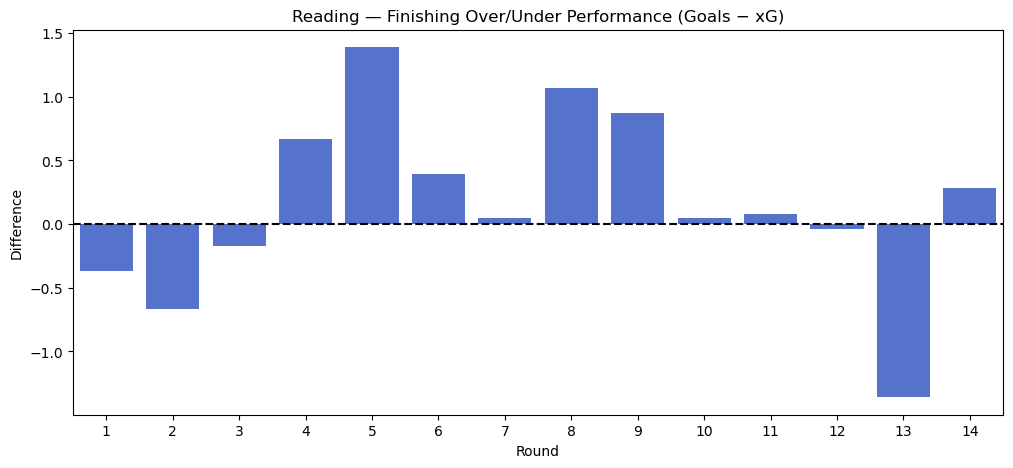

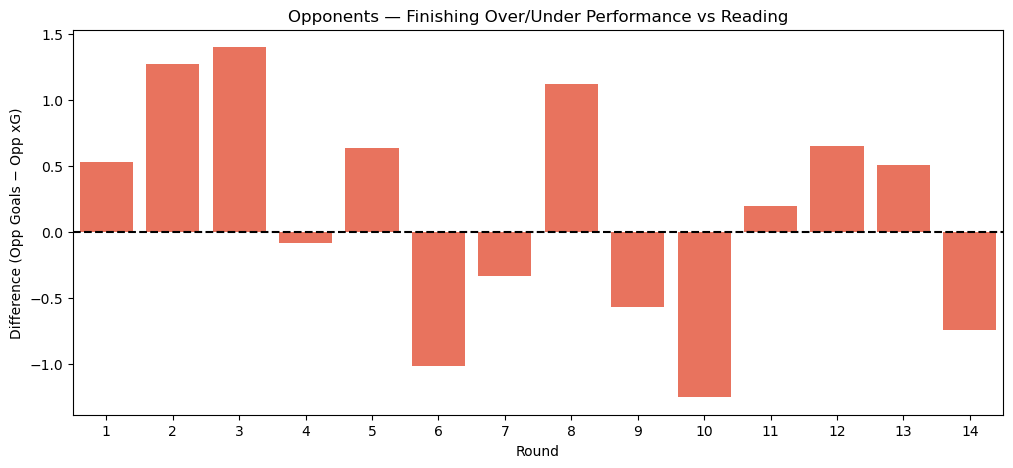

In [76]:
plt.figure(figsize=(12,5))
sns.barplot(data=df, x='Round', y='Goals_minus_xG', color='royalblue')
plt.axhline(0, ls='--', c='black')
plt.title("Reading — Finishing Over/Under Performance (Goals − xG)")
plt.ylabel("Difference")
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=df, x='Round', y='OppGoals_minus_opp_xG', color='tomato')
plt.axhline(0, ls='--', c='black')
plt.title("Opponents — Finishing Over/Under Performance vs Reading")
plt.ylabel("Difference (Opp Goals − Opp xG)")
plt.show()


In [77]:
summary = pd.DataFrame({
    "Metric" : ["Average RFC xG", "Average RFC Goals", "Avg RFC xG per shot", "Avg Opp xG", "Avg Opp Goals", "Avg Opp xG per shot"],
    "Value" : [
        df['rfc_xG'].mean(),
        df['rfc_Score'].mean(),
        df['rfc_xG_per_shot'].mean(),
        df['opp_xG'].mean(),
        df['opp_Score'].mean(),
        df['opp_xG_per_shot'].mean(),
    ]
})

print(summary)


                Metric     Value
0       Average RFC xG  0.911429
1    Average RFC Goals  1.071429
2  Avg RFC xG per shot  0.076091
3           Avg Opp xG  1.190000
4        Avg Opp Goals  1.357143
5  Avg Opp xG per shot  0.101593


# Game Play Performance

In [83]:
# ---------- Helpers ----------
def ensure_total(col):
    c1, c2 = f"{col}_1st", f"{col}_2nd"
    if col not in df.columns and c1 in df.columns and c2 in df.columns:
        df[col] = df[c1] + df[c2]

def safe_div(a, b):
    return np.where((b==0) | (pd.isna(b)), 0, a / b)

# Fix possession typo + totals we’ll use
if 'rfc_Possesion' in df.columns: df['rfc_Possession'] = df['rfc_Possesion']
elif {'rfc_Possession_1st','rfc_Possession_2nd'}.issubset(df.columns):
    df['rfc_Possession'] = (df['rfc_Possession_1st'] + df['rfc_Possession_2nd'])/2

if 'opp_Possesion' in df.columns: df['opp_Possession'] = df['opp_Possesion']
elif {'opp_Possession_1st','opp_Possession_2nd'}.issubset(df.columns):
    df['opp_Possession'] = (df['opp_Possession_1st'] + df['opp_Possession_2nd'])/2

for col in [
    'rfc_xG','opp_xG',
    'rfc_Shots','opp_Shots',
    'rfc_SOT','opp_SOT',
    'rfc_Passes','opp_Passes',
    'rfc_Passes_In_Final_Third','opp_Passes_In_Final_Third',
    'rfc_Touches_In_Opp_Box','opp_Touches_In_Opp_Box',
    'rfc_Crosses','opp_Crosses',
    'rfc_Interceptions','opp_Interceptions',
    'rfc_Tackles','opp_Tackles'
]:
    ensure_total(col)

# Round ordering
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values(['Date','Round'], na_position='last').reset_index(drop=True)
else:
    df = df.sort_values('Round').reset_index(drop=True)

W = 5  # rolling window

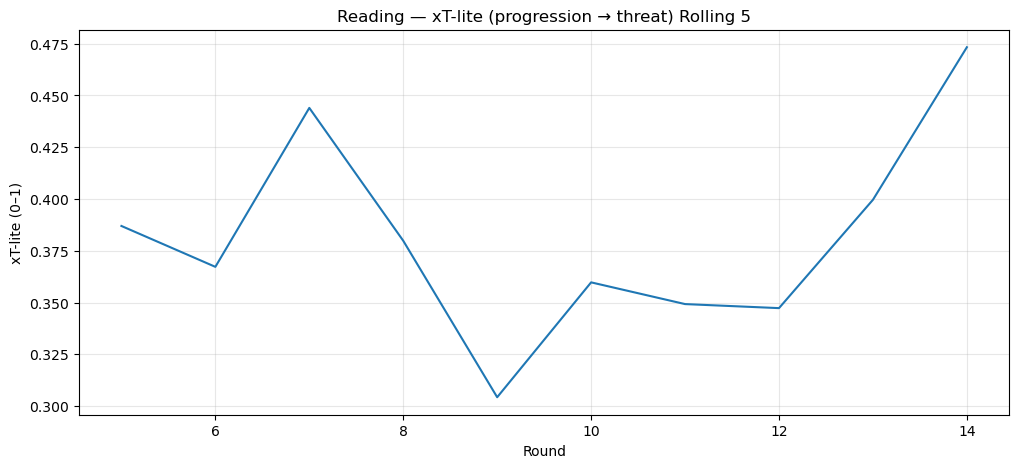

In [84]:
# =======================================================================
# 1) xThreat / Progressive Passes Index (xT-lite)
#    (coordinate-free proxy using final-third entries & box touches)
# =======================================================================
# Progressive proxy = passes completed into final third
df['rfc_Progressions'] = df['rfc_Passes_In_Final_Third']
df['opp_Progressions'] = df['opp_Passes_In_Final_Third']

# xT-lite = weighted, normalized combination of progression -> box touch -> xG yield
df['rfc_xG_per_progression'] = safe_div(df['rfc_xG'], df['rfc_Progressions'])
df['rfc_xG_per_boxtouch']   = safe_div(df['rfc_xG'], df['rfc_Touches_In_Opp_Box'])

# scale to 0–1 within season for comparability
def minmax(series):
    s = series.astype(float)
    mn, mx = np.nanmin(s), np.nanmax(s)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx==mn:
        return pd.Series(np.zeros(len(s)), index=series.index)
    return (s - mn) / (mx - mn)

df['xTlite'] = (
    0.4 * minmax(df['rfc_Progressions']) +
    0.3 * minmax(df['rfc_Touches_In_Opp_Box']) +
    0.3 * minmax(df['rfc_xG_per_progression'])
)

df['roll_xTlite'] = df['xTlite'].rolling(W).mean()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Round', y='roll_xTlite')
plt.title(f"Reading — xT-lite (progression → threat) Rolling {W}")
plt.ylabel("xT-lite (0–1)")
plt.grid(alpha=0.3)
plt.show()

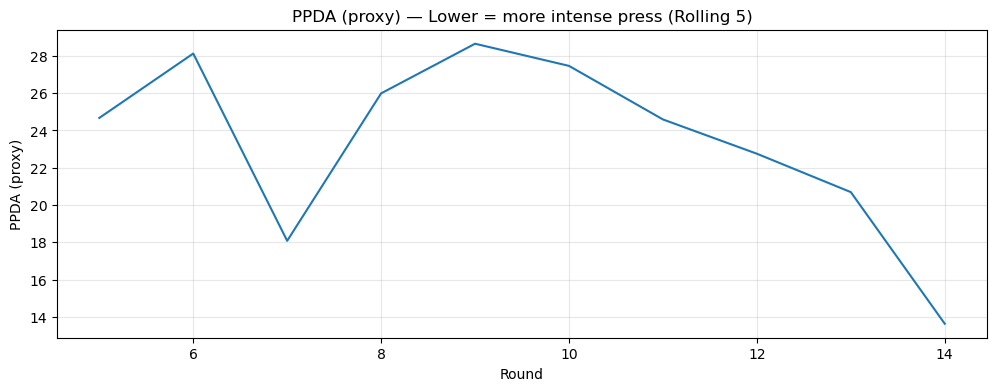

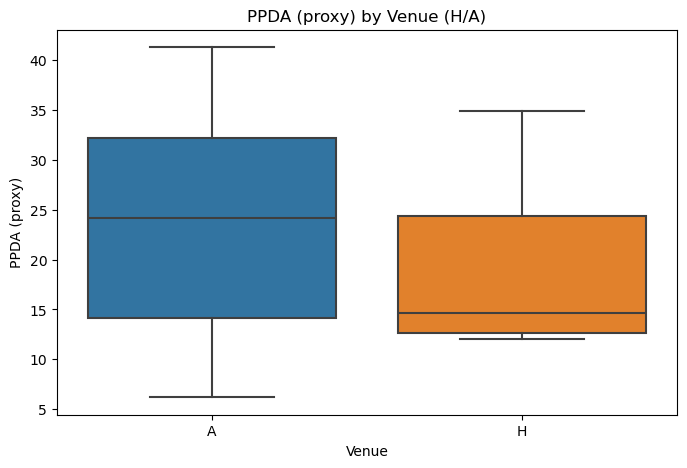

In [85]:
# =======================================================================
# 2) PPDA (Pressing) — Proxy
#    PPDA ≈ Opponent passes / (RFC defensive actions). We lack locations,
#    so use RFC tackles + interceptions as DA proxy.
#    Lower PPDA => more intense pressing.
# =======================================================================
df['rfc_def_actions'] = (df.get('rfc_Tackles',0) + df.get('rfc_Interceptions',0)).astype(float)
df['PPDA_proxy'] = safe_div(df['opp_Passes'], df['rfc_def_actions'])
df['roll_PPDA'] = pd.Series(df['PPDA_proxy']).rolling(W).mean()

plt.figure(figsize=(12,4))
sns.lineplot(data=df, x='Round', y='roll_PPDA')
plt.title(f"PPDA (proxy) — Lower = more intense press (Rolling {W})")
plt.ylabel("PPDA (proxy)")
plt.grid(alpha=0.3)
plt.show()

# Optional: compare venues
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Venue', y='PPDA_proxy')
plt.title("PPDA (proxy) by Venue (H/A)")
plt.ylabel("PPDA (proxy)")
plt.show()

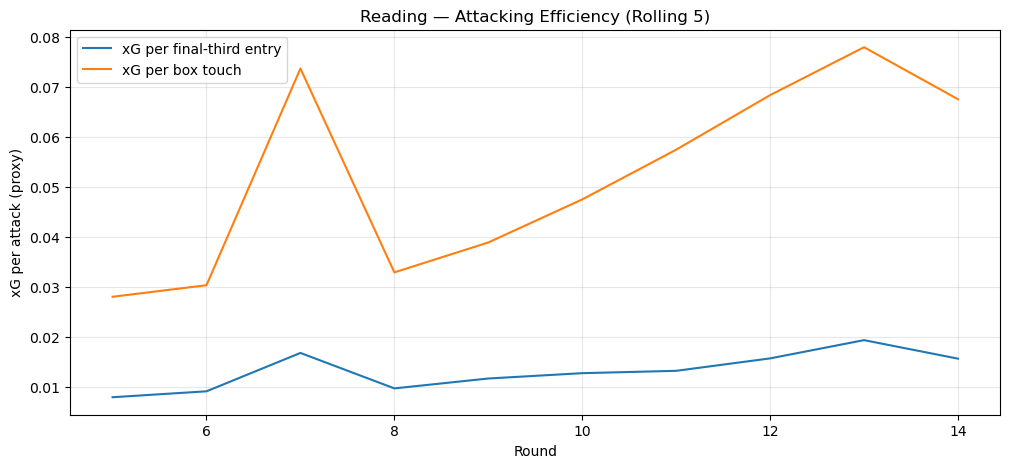

In [86]:
# =======================================================================
# 3) Attacking efficiency — xG per attack
#    Define 'attack' as a final-third entry (proxy) and as a box touch.
# =======================================================================
df['xG_per_attack_F3'] = safe_div(df['rfc_xG'], df['rfc_Progressions'])
df['xG_per_attack_Box'] = safe_div(df['rfc_xG'], df['rfc_Touches_In_Opp_Box'])
df['roll_xG_per_attack_F3'] = pd.Series(df['xG_per_attack_F3']).rolling(W).mean()
df['roll_xG_per_attack_Box'] = pd.Series(df['xG_per_attack_Box']).rolling(W).mean()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Round', y='roll_xG_per_attack_F3', label='xG per final-third entry')
sns.lineplot(data=df, x='Round', y='roll_xG_per_attack_Box', label='xG per box touch')
plt.title(f"Reading — Attacking Efficiency (Rolling {W})")
plt.ylabel("xG per attack (proxy)")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

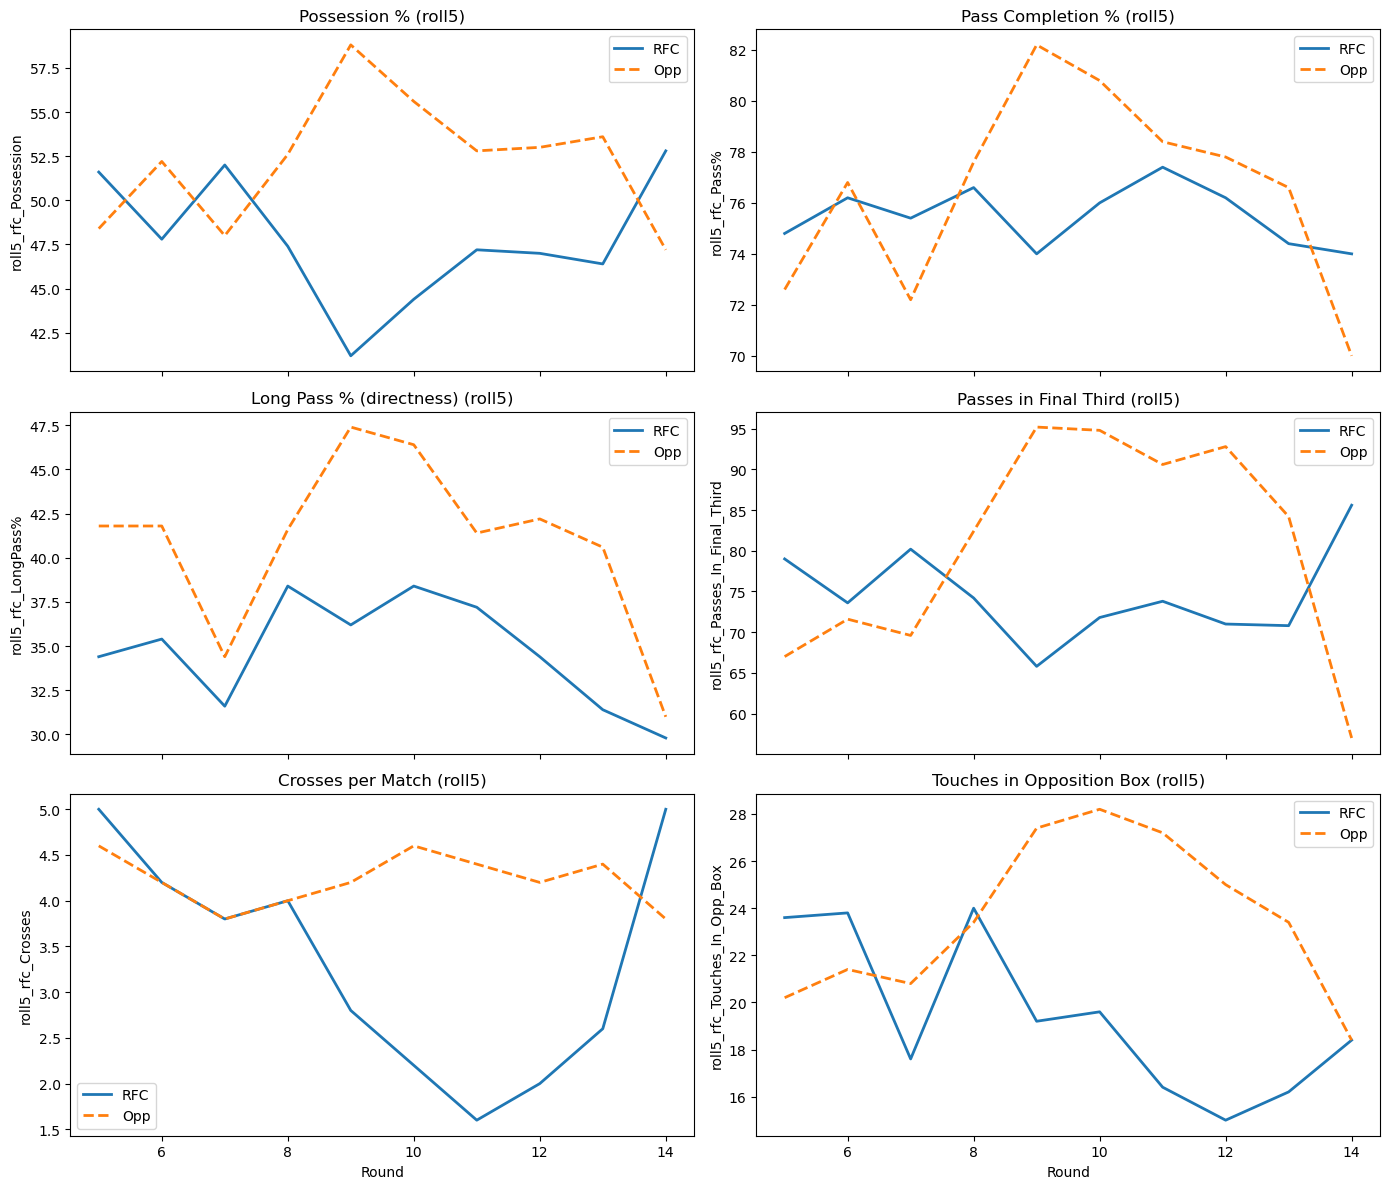

In [78]:
# Fix possession 
if 'rfc_Possesion' in df.columns:
    df['rfc_Possession'] = df['rfc_Possesion']
else:
    df['rfc_Possession'] = (df['rfc_Possession_1st'] + df['rfc_Possession_2nd']) / 2

if 'opp_Possesion' in df.columns:
    df['opp_Possession'] = df['opp_Possesion']
else:
    df['opp_Possession'] = (df['opp_Possession_1st'] + df['opp_Possession_2nd']) / 2

# Create totals if only halves exist
def ensure_total(col_base):
    first = col_base + '_1st'
    second = col_base + '_2nd'
    total = col_base
    
    if total not in df.columns and first in df.columns and second in df.columns:
        df[total] = df[first] + df[second]

# Columns to construct if missing
for base in [
    'rfc_Passes_In_Final_Third', 'opp_Passes_In_Final_Third',
    'rfc_Crosses', 'opp_Crosses',
    'rfc_Touches_In_Opp_Box', 'opp_Touches_In_Opp_Box'
]:
    ensure_total(base)

# Rolling smoother
for col in [
    'rfc_Possession','opp_Possession',
    'rfc_Pass%','opp_Pass%',
    'rfc_LongPass%','opp_LongPass%',
    'rfc_Passes_In_Final_Third','opp_Passes_In_Final_Third',
    'rfc_Crosses','opp_Crosses',
    'rfc_Touches_In_Opp_Box','opp_Touches_In_Opp_Box'
]:
    df[f'roll5_{col}'] = df[col].rolling(5).mean()

# Plot style comparison
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
axes = axes.ravel()

# 1 — Possession
sns.lineplot(data=df, x='Round', y='roll5_rfc_Possession', ax=axes[0], label='RFC', linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_opp_Possession', ax=axes[0], label='Opp', linestyle='--', linewidth=2)
axes[0].set_title('Possession % (roll5)')

# 2 — Pass %
sns.lineplot(data=df, x='Round', y='roll5_rfc_Pass%', ax=axes[1], label='RFC', linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_opp_Pass%', ax=axes[1], label='Opp', linestyle='--', linewidth=2)
axes[1].set_title('Pass Completion % (roll5)')

# 3 — Long Pass %
sns.lineplot(data=df, x='Round', y='roll5_rfc_LongPass%', ax=axes[2], label='RFC', linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_opp_LongPass%', ax=axes[2], label='Opp', linestyle='--', linewidth=2)
axes[2].set_title('Long Pass % (directness) (roll5)')

# 4 — Passes in Final Third
sns.lineplot(data=df, x='Round', y='roll5_rfc_Passes_In_Final_Third', ax=axes[3], label='RFC', linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_opp_Passes_In_Final_Third', ax=axes[3], label='Opp', linestyle='--', linewidth=2)
axes[3].set_title('Passes in Final Third (roll5)')

# 5 — Crosses
sns.lineplot(data=df, x='Round', y='roll5_rfc_Crosses', ax=axes[4], label='RFC', linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_opp_Crosses', ax=axes[4], label='Opp', linestyle='--', linewidth=2)
axes[4].set_title('Crosses per Match (roll5)')

# 6 — Touches in Opp Box
sns.lineplot(data=df, x='Round', y='roll5_rfc_Touches_In_Opp_Box', ax=axes[5], label='RFC', linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_opp_Touches_In_Opp_Box', ax=axes[5], label='Opp', linestyle='--', linewidth=2)
axes[5].set_title('Touches in Opposition Box (roll5)')

for ax in axes: ax.legend()
plt.tight_layout()
plt.show()

In [81]:
# Ensure totals exist
def ensure_total(col):
    if col not in df.columns and f"{col}_1st" in df.columns and f"{col}_2nd" in df.columns:
        df[col] = df[f"{col}_1st"] + df[f"{col}_2nd"]

ensure_total('rfc_Passes_In_Final_Third')
ensure_total('opp_Passes_In_Final_Third')

# Calculate field tilt
df['field_tilt'] = df['rfc_Passes_In_Final_Third'] / (
    df['rfc_Passes_In_Final_Third'] + df['opp_Passes_In_Final_Third']
)

# Handle divide-by-zero cases
df['field_tilt'] = df['field_tilt'].fillna(0)


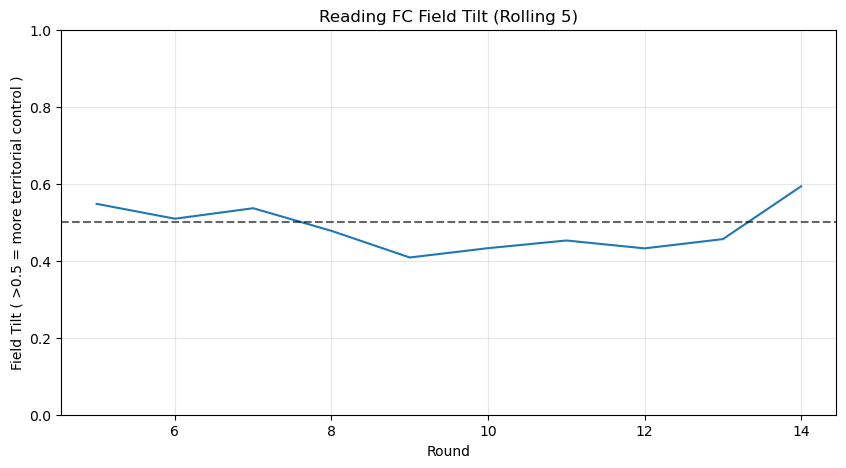

In [82]:
df['roll5_field_tilt'] = df['field_tilt'].rolling(5).mean()

plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='Round', y='roll5_field_tilt')
plt.axhline(0.5, ls='--', c='black', alpha=0.6)
plt.title('Reading FC Field Tilt (Rolling 5)')
plt.ylabel('Field Tilt ( >0.5 = more territorial control )')
plt.xlabel('Round')
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.show()


# Defensive Performance

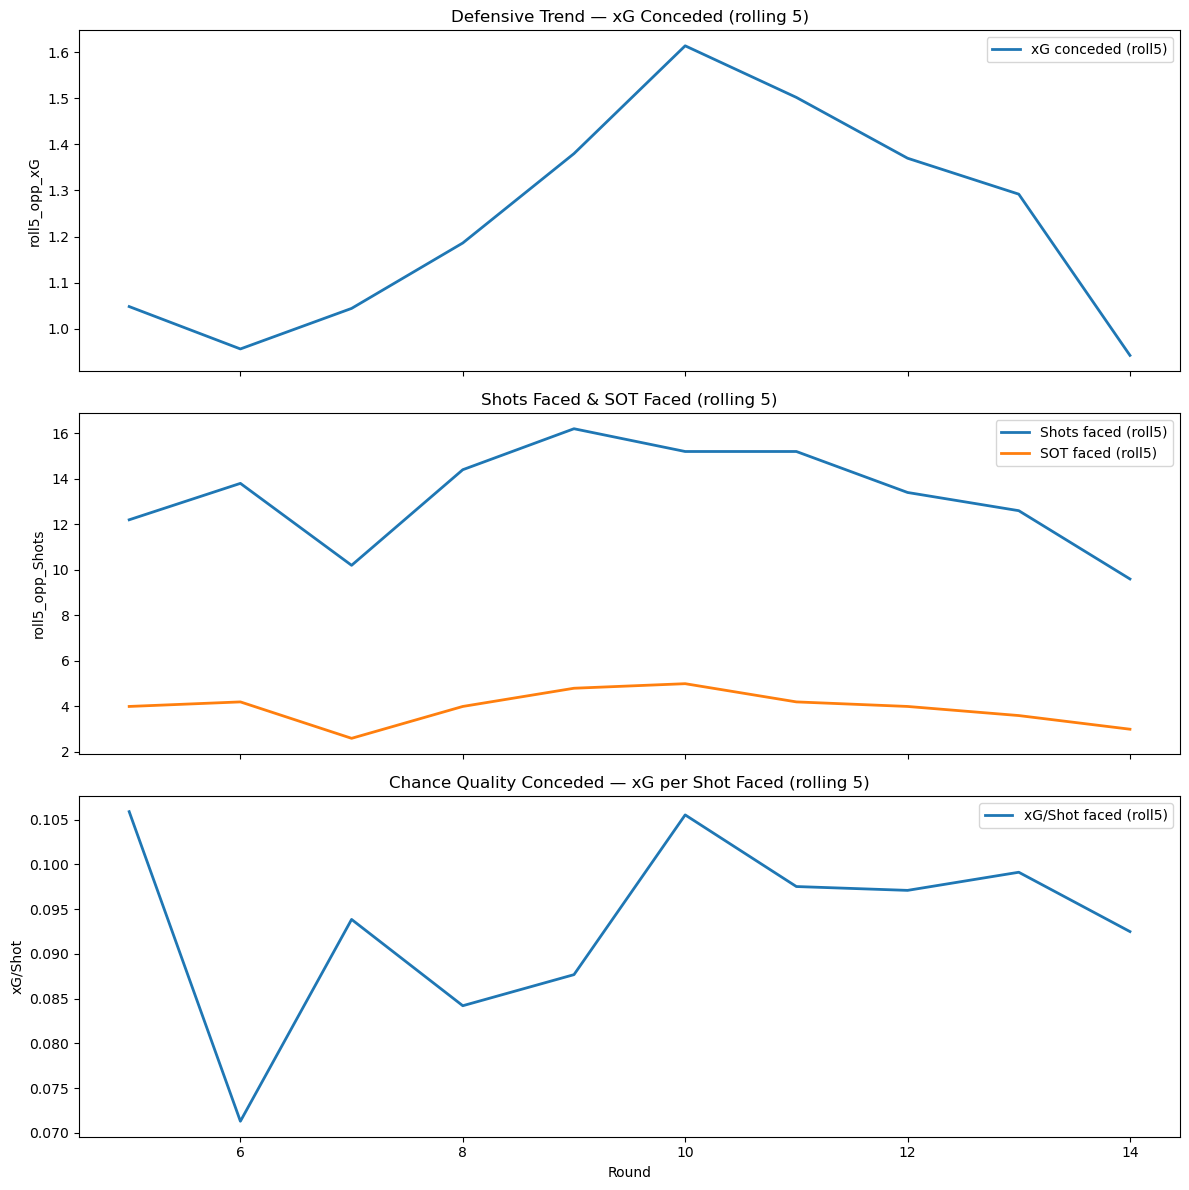

In [ ]:
def safe_div(a, b):
    return np.where(b==0, 0, a / b)

df['opp_xG'] = df['opp_xG_1st'] + df['opp_xG_2nd']
df['opp_Shots'] = df['opp_Shots_1st'] + df['opp_Shots_2nd']
df['opp_SOT']   = df['opp_SOT_1st'] + df['opp_SOT_2nd']

df['roll5_opp_xG']   = df['opp_xG'].rolling(5).mean()
df['roll5_opp_Shots']= df['opp_Shots'].rolling(5).mean()
df['roll5_opp_SOT']  = df['opp_SOT'].rolling(5).mean()

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
sns.lineplot(data=df, x='Round', y='roll5_opp_xG', label='xG conceded (roll5)', ax=axes[0], linewidth=2)
axes[0].set_title("Defensive Trend — xG Conceded (rolling 5)")

sns.lineplot(data=df, x='Round', y='roll5_opp_Shots', label='Shots faced (roll5)', ax=axes[1], linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_opp_SOT', label='SOT faced (roll5)', ax=axes[1], linewidth=2)
axes[1].set_title("Shots Faced & SOT Faced (rolling 5)")
axes[1].legend()

# xG per shot faced (shot quality conceded)
df['xG_per_shot_faced'] = safe_div(df['opp_xG'], df['opp_Shots'])
df['roll5_xG_per_shot_faced'] = df['xG_per_shot_faced'].rolling(5).mean()
sns.lineplot(data=df, x='Round', y='roll5_xG_per_shot_faced', label='xG/Shot faced (roll5)', ax=axes[2], linewidth=2)
axes[2].set_title("Chance Quality Conceded — xG per Shot Faced (rolling 5)")
axes[2].set_ylabel("xG/Shot")
plt.tight_layout()
plt.show()

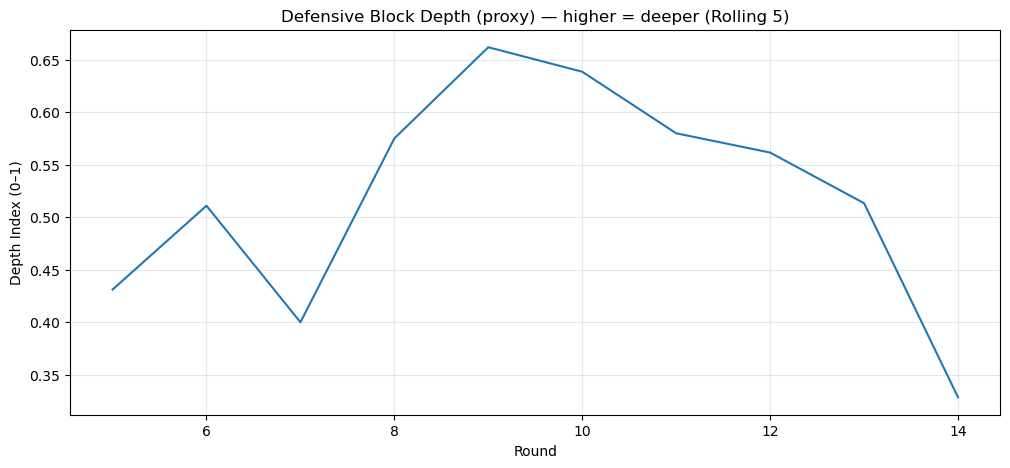

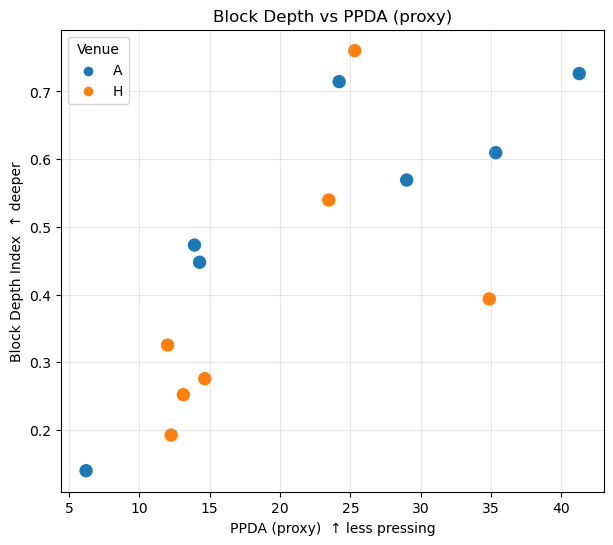

In [89]:
# =======================================================================
# 4) Defensive block depth — Proxy
#    Heuristic: deeper block when:
#      - Our possession is low,
#      - Our long pass % is high (more direct clearances/outs),
#      - Opponent achieves relatively more final-third passes vs us.
#    Normalize each component to 0–1 and combine.
# =======================================================================
components = {}
components['low_possession'] = 1 - minmax(df['rfc_Possession'])
components['high_longball']  = minmax(df['rfc_LongPass%'])
# opponent territorial share (their F3 passes share)
total_F3 = df['rfc_Passes_In_Final_Third'] + df['opp_Passes_In_Final_Third']
components['opp_territory_share'] = pd.Series(safe_div(df['opp_Passes_In_Final_Third'], total_F3), index=df.index)
components['opp_territory_share'] = minmax(components['opp_territory_share'])

df['block_depth_index'] = (0.4*components['low_possession'] +
                           0.3*components['high_longball'] +
                           0.3*components['opp_territory_share'])

df['roll_block_depth'] = df['block_depth_index'].rolling(W).mean()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Round', y='roll_block_depth')
plt.title(f"Defensive Block Depth (proxy) — higher = deeper (Rolling {W})")
plt.ylabel("Depth Index (0–1)")
plt.grid(alpha=0.3)
plt.show()

# Show relationship vs PPDA proxy (deeper blocks often correlate with higher PPDA)
plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x='PPDA_proxy', y='block_depth_index', hue='Venue', s=110)
plt.title("Block Depth vs PPDA (proxy)")
plt.xlabel("PPDA (proxy)  ↑ less pressing")
plt.ylabel("Block Depth Index  ↑ deeper")
plt.grid(alpha=0.3)
plt.show()

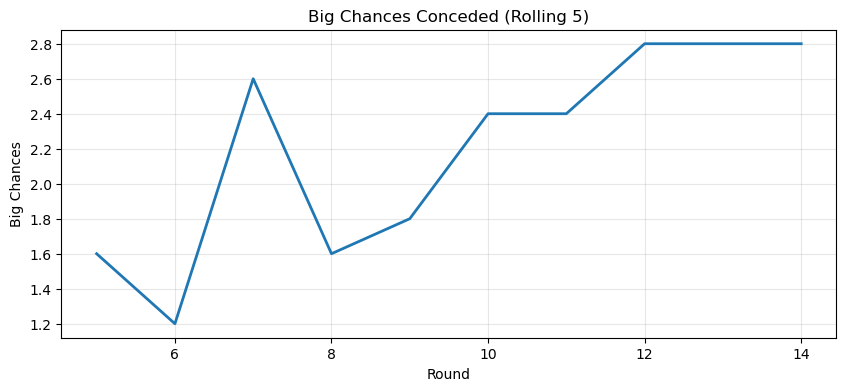

In [90]:
df['opp_BigChances'] = df['opp_BigChances_1st'] + df['opp_BigChances_2nd']
df['roll5_opp_BigChances'] = df['opp_BigChances'].rolling(5).mean()

plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Round', y='roll5_opp_BigChances', linewidth=2)
plt.title("Big Chances Conceded (Rolling 5)")
plt.ylabel("Big Chances")
plt.grid(alpha=0.3)
plt.show()


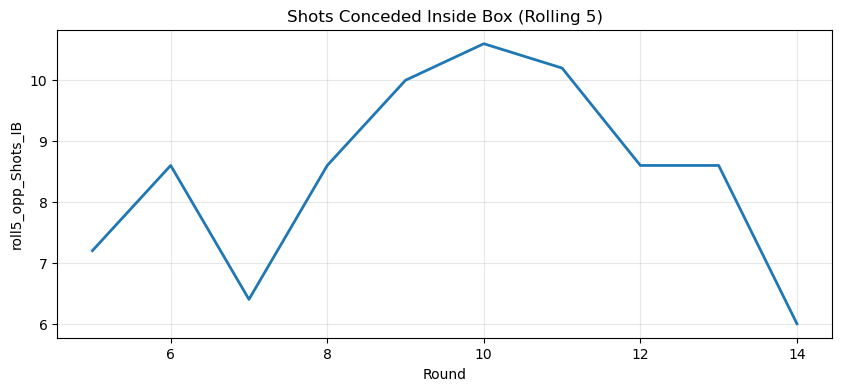

In [91]:
df['opp_Shots_IB'] = df['opp_Shots_Inside_Box_1st'] + df['opp_Shots_Inside_Box_2nd']
df['roll5_opp_Shots_IB'] = df['opp_Shots_IB'].rolling(5).mean()

plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Round', y='roll5_opp_Shots_IB', linewidth=2)
plt.title("Shots Conceded Inside Box (Rolling 5)")
plt.grid(alpha=0.3)
plt.show()


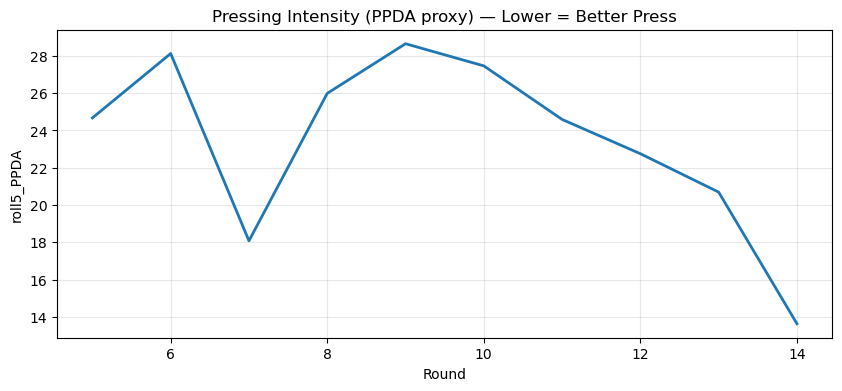

In [92]:
df['opp_Passes'] = df['opp_Passes_1st'] + df['opp_Passes_2nd']
df['rfc_DefActions'] = (df['rfc_Tackles_1st'] + df['rfc_Tackles_2nd'] +
                        df['rfc_Interceptions_1st'] + df['rfc_Interceptions_2nd'])

df['PPDA_proxy'] = np.where(df['rfc_DefActions']==0, 
                            np.nan,
                            df['opp_Passes'] / df['rfc_DefActions'])

df['roll5_PPDA'] = df['PPDA_proxy'].rolling(5).mean()

plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Round', y='roll5_PPDA', linewidth=2)
plt.title("Pressing Intensity (PPDA proxy) — Lower = Better Press")
plt.grid(alpha=0.3)
plt.show()


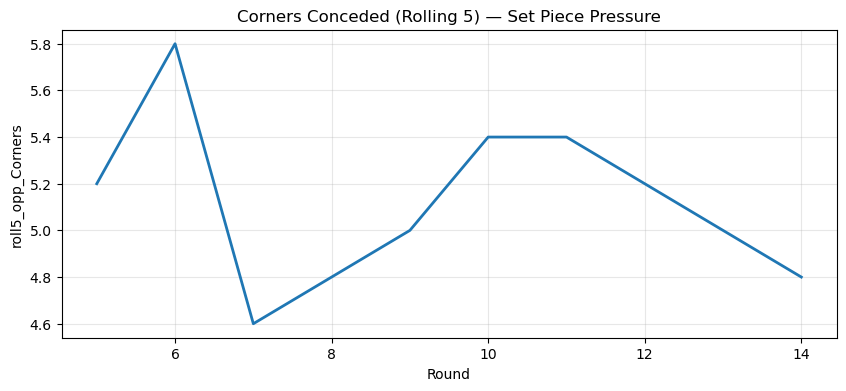

In [93]:
df['opp_Corners'] = df['opp_Corners_1st'] + df['opp_Corners_2nd']
df['roll5_opp_Corners'] = df['opp_Corners'].rolling(5).mean()

plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='Round', y='roll5_opp_Corners', linewidth=2)
plt.title("Corners Conceded (Rolling 5) — Set Piece Pressure")
plt.grid(alpha=0.3)
plt.show()


# Goalkeeper Performance

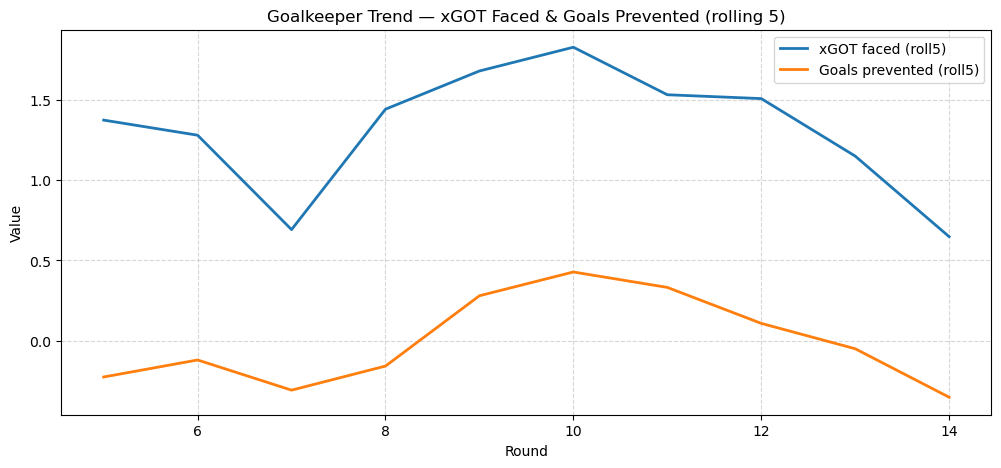

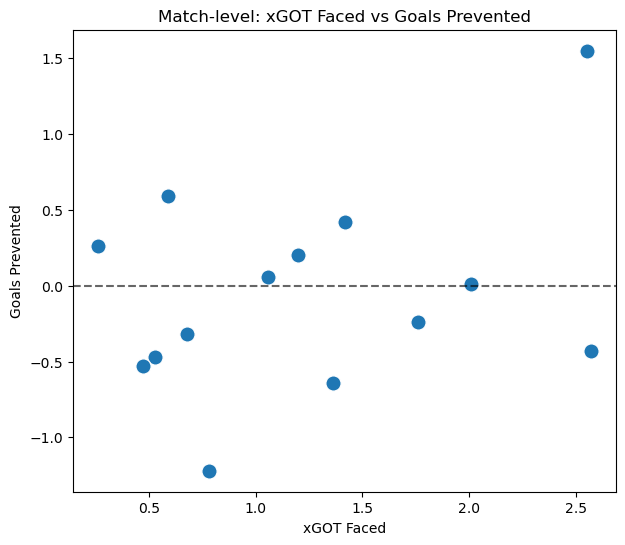

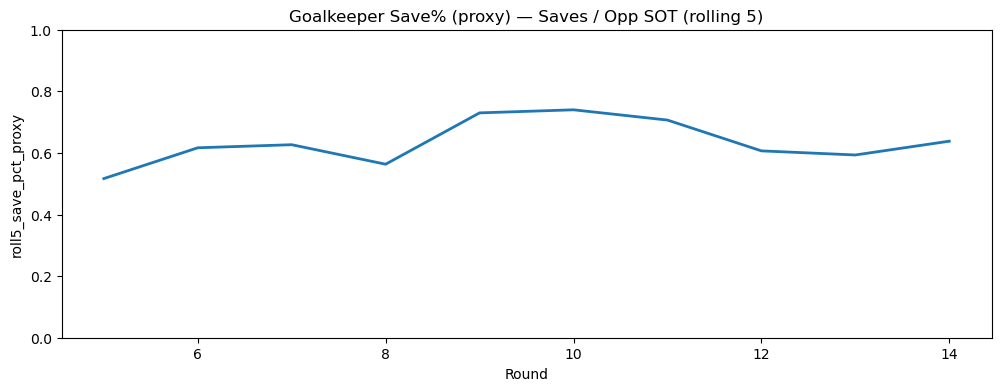

In [ ]:
# Totals and rolling
df['rfc_xGOT_Faced'] = df['rfc_xGOT_Faced_1st'] + df['rfc_xGOT_Faced_2nd']
df['rfc_GK_Saves_tot'] = df['rfc_GK_Saves_1st'] + df['rfc_GK_Saves_2nd']
df['rfc_GK_Goals_Prevented_tot'] = df['rfc_GK_Goals_Prevented_1st'] + df['rfc_GK_Goals_Prevented_2nd']

df['roll5_xGOT'] = df['rfc_xGOT_Faced'].rolling(5).mean()
df['roll5_GP'] = df['rfc_GK_Goals_Prevented_tot'].rolling(5).mean()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='Round', y='roll5_xGOT', label='xGOT faced (roll5)', linewidth=2)
sns.lineplot(data=df, x='Round', y='roll5_GP', label='Goals prevented (roll5)', linewidth=2)
plt.title("Goalkeeper Trend — xGOT Faced & Goals Prevented (rolling 5)")
plt.xlabel("Round"); plt.ylabel("Value"); plt.grid(True, ls='--', alpha=0.5); plt.legend()
plt.show()

plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x='rfc_xGOT_Faced', y='rfc_GK_Goals_Prevented_tot', s=120)
plt.title("Match-level: xGOT Faced vs Goals Prevented")
plt.xlabel("xGOT Faced"); plt.ylabel("Goals Prevented")
plt.axhline(0, ls='--', c='k', alpha=0.6)
plt.show()

# Save% proxy (SOT faced needed)
df['save_pct_proxy'] = safe_div(df['rfc_GK_Saves_tot'], df['opp_SOT'])
df['roll5_save_pct_proxy'] = df['save_pct_proxy'].rolling(5).mean()

plt.figure(figsize=(12,4))
sns.lineplot(data=df, x='Round', y='roll5_save_pct_proxy', linewidth=2)
plt.title("Goalkeeper Save% (proxy) — Saves / Opp SOT (rolling 5)")
plt.ylim(0,1)
plt.show()